**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2023</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Mehmet Berk Türkçapar</center></h4>
<h4><center>21902570</center></h4>

## **MNIST RGB Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train two different neural network models for image the inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the MNIST RGB dataset, which is created for this homework by processing a subset of the original [MNIST](http://yann.lecun.com/exdb/mnist/) images. It contains RGB digit images from 0 to 1 colored in black, red, blue, or green. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![MNIST RGB Samples](https://drive.google.com/uc?export=view&id=1uy0VENXeb6If-i3uxgDVtnk4qDj7eq_3)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'. 

**Do not change the cell**.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. 

**Do not change the cell**

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
seed_everything(464)

### **Preparing the Dataset**

The MNIST RGB dataset is downloadable from [this link](https://drive.google.com/file/d/1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [6]:
import gdown # Library to download files from Google Drive
!gdown 1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ # Google Drive ID of the zip file to be downloaded
!unzip -oq mnist_dataset_rgb # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

Downloading...
From: https://drive.google.com/uc?id=1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ
To: /content/mnist_dataset_rgb.zip
100% 63.4M/63.4M [00:00<00:00, 142MB/s]


In [7]:
!ls
!pwd

mnist_dataset_rgb  mnist_dataset_rgb.zip  sample_data
/content


### **Implementing a Custom Dataset [20 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads MNIST RGB images from a dataset split folder. There are two split folders called training and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [8]:
class MnistDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        # classes indicate each digit
        self.classes = sorted(os.listdir(self.root_dir))
        images = []
        for class_dir in self.classes:
            class_path = os.path.join(self.root_dir, class_dir)
            for filename in os.listdir(class_path):
                image_path = os.path.join(class_path, filename)
                image = Image.open(image_path).convert('RGB')
                image = image.resize((32, 32), Image.BICUBIC)
                image = transforms.ToTensor()(image)
                image = transforms.Normalize((0.5,), (0.5,))(image)
                images.append(image)
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, data_id):
        return self.images[data_id]

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [9]:
# Define the root directories for the train and test splits
train_root_dir = "mnist_dataset_rgb/training"
test_root_dir = "mnist_dataset_rgb/test"

# Define the transformation pipelines
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the train dataset and data loader
train_dataset = MnistDataset(train_root_dir)
batch_size_train = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

# Create the test dataset and data loader
test_dataset = MnistDataset(test_root_dir)
batch_size_test = 512
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of MNIST RGB images properly.

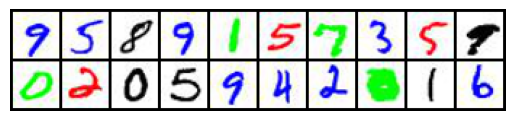

In [10]:
## Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader))
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Autoencoder Networks [30 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two subnetworks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part of the homework, you are requested to implement two different autoencoder networks, which are fully connected and convolutional autoencoders.

#### **Fully Connected Autoencoder [15 Points]**

Fully connected networks consist of multiple [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). The figure of the architecture is provided below, where the number of nodes is kept small for simplification. 

![Fully Connected Autoencoder Architecture](https://drive.google.com/uc?export=view&id=1JeDQtjvWVoT5dZhVxesQp_XiqAnUvi1i)

In this part, you are requested to implement the layers and the forward function of the model. You should flatten the input image before feeding it to the network and unflatten it when the final activations are obtained. The (input_size, output_size) pairs of the layers should be defined as follows:

**Encoder:**
- (3\*32\*32, 256)
- (256, 64)
- (64, 16)

**Decoder:**
- (16, 64)
- (64, 256)
- (256, 3\*32\*32)

In each layer, [1D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In [11]:
class MnistAutoencoderFC(nn.Module):
    def __init__(self):
        super(MnistAutoencoderFC, self).__init__()

        # Define the encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 3 * 32 * 32),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.to(device)
        x = x.view(x.size(0), -1)  # Flatten the input image

        # Pass the input through the encoder
        encoded = self.encoder(x)

        # Pass the encoded representation through the decoder
        decoded = self.decoder(encoded)

        # Reshape the output to match the original input shape
        decoded = decoded.view(decoded.size(0), 3, 32, 32)

        return decoded

#### **Convolutional Autoencoder [15 Points]**

In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of a convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=18Ztf-zhMFC_IXDTnvGCUeGgZx-7duu0o)

 The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers. 

In the encoder part of the network, use max pooling in each layer for decreasing the resolution. The stride size should be set to one in these layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back. 

In [12]:
class MnistAutoencoderConv(nn.Module):
    def __init__(self):
        super(MnistAutoencoderConv, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.to(device)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train both the fully connected and the convolutional autoencoders. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![MNIST Masking](https://drive.google.com/uc?export=view&id=1gIELbRSE188PQHv_uGktPX_2cvAtMbN-)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [13]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    losses = []
    model.to(device)  # Move the model to the desired device
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        running_loss = 0.0

        for data in train_dataloader:
            data = data.to(device)
            inputs = data.clone()  # Clone the input data for later use in the loss function
            inputs[:, :, :, 16:32] = -1  # Set the masked region to -1 (black pixel)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = loss_func(outputs, data)
            running_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / len(train_dataloader)
        losses.append(epoch_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.8f}")

    return losses

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [25]:
def evaluate_model(model, test_dataloader):
    model.to(device)  # Move the model to the desired device
    criterion = nn.MSELoss()
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for data in test_dataloader:
            data = data.to(device)  # Move the data to the desired device
            inputs = data.clone()
            inputs[:, :, :, 16:32] = -1  # Set the masked region to -1 (black pixel)

            outputs = model(inputs)

            loss = criterion(outputs, data)
            total_loss += loss.item() * data.size(0)  # Multiply by batch size to account for different batch sizes
            num_samples += data.size(0)

    mean_mse = total_loss / num_samples

    return mean_mse

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. 

**Do not change the cell**

In [15]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the FC Model [5 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the accuracy the model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



Epoch 1/50, Loss: 0.14588120
Epoch 2/50, Loss: 0.08060783
Epoch 3/50, Loss: 0.07254839
Epoch 4/50, Loss: 0.06821324
Epoch 5/50, Loss: 0.06541772
Epoch 6/50, Loss: 0.06336723
Epoch 7/50, Loss: 0.06163822
Epoch 8/50, Loss: 0.06056346
Epoch 9/50, Loss: 0.05933505
Epoch 10/50, Loss: 0.05832948
Epoch 11/50, Loss: 0.05751027
Epoch 12/50, Loss: 0.05674126
Epoch 13/50, Loss: 0.05625911
Epoch 14/50, Loss: 0.05569439
Epoch 15/50, Loss: 0.05503016
Epoch 16/50, Loss: 0.05460015
Epoch 17/50, Loss: 0.05407610
Epoch 18/50, Loss: 0.05357761
Epoch 19/50, Loss: 0.05319069
Epoch 20/50, Loss: 0.05285866
Epoch 21/50, Loss: 0.05244024
Epoch 22/50, Loss: 0.05223179
Epoch 23/50, Loss: 0.05186692
Epoch 24/50, Loss: 0.05163274
Epoch 25/50, Loss: 0.05125320
Epoch 26/50, Loss: 0.05105439
Epoch 27/50, Loss: 0.05087436
Epoch 28/50, Loss: 0.05053854
Epoch 29/50, Loss: 0.05036988
Epoch 30/50, Loss: 0.05011416
Epoch 31/50, Loss: 0.04985850
Epoch 32/50, Loss: 0.04978852
Epoch 33/50, Loss: 0.04955548
Epoch 34/50, Loss: 

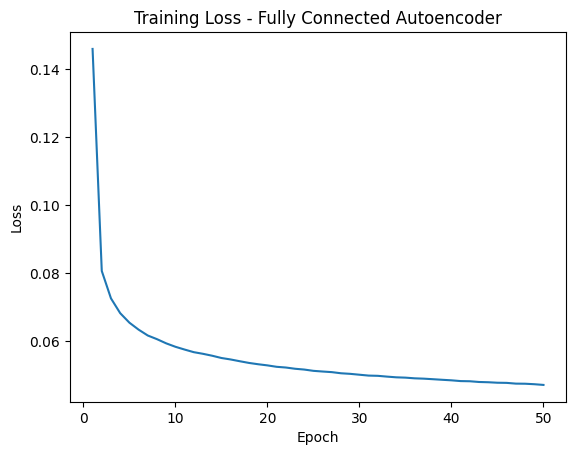

Mean MSE on test dataset - Fully Connected Autoencoder: 0.04774


In [27]:
seed_everything(464)
model_fc = MnistAutoencoderFC().cuda() ## Uncomment when the model is implemented

# Set hyperparameters
learning_rate = 2e-4
num_epochs = 50

# Define the loss function
loss_func = nn.MSELoss()

# Create the optimizer
optimizer = optim.Adam(model_fc.parameters(), lr=learning_rate)

# Train the model
losses_fc = train_model(model_fc, train_dataloader, optimizer, loss_func, num_epochs)

# Visualize the losses
plt.plot(range(1, num_epochs + 1), losses_fc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss - Fully Connected Autoencoder')
plt.show()

# Evaluate the model
mean_mse_fc = evaluate_model(model_fc, test_dataloader)
print(f"Mean MSE on test dataset - Fully Connected Autoencoder: {mean_mse_fc:.5f}")

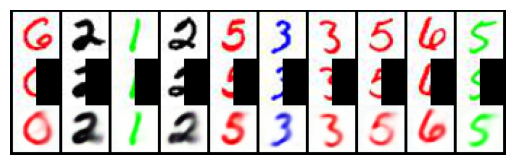

In [28]:
visualize_inpainting(model_fc, test_dataset) ## Uncomment when the model is trained

### **Training and Evaluating the Convolutional Model [5 Points]**

Apply the same steps given in the FC Autoencoder part.

Epoch 1/50, Loss: 0.15379524
Epoch 2/50, Loss: 0.05925923
Epoch 3/50, Loss: 0.05160940
Epoch 4/50, Loss: 0.04829330
Epoch 5/50, Loss: 0.04626523
Epoch 6/50, Loss: 0.04477225
Epoch 7/50, Loss: 0.04373317
Epoch 8/50, Loss: 0.04284784
Epoch 9/50, Loss: 0.04199230
Epoch 10/50, Loss: 0.04137929
Epoch 11/50, Loss: 0.04070601
Epoch 12/50, Loss: 0.04012918
Epoch 13/50, Loss: 0.03964552
Epoch 14/50, Loss: 0.03926991
Epoch 15/50, Loss: 0.03890272
Epoch 16/50, Loss: 0.03848630
Epoch 17/50, Loss: 0.03812831
Epoch 18/50, Loss: 0.03786845
Epoch 19/50, Loss: 0.03758092
Epoch 20/50, Loss: 0.03745087
Epoch 21/50, Loss: 0.03703646
Epoch 22/50, Loss: 0.03690523
Epoch 23/50, Loss: 0.03663160
Epoch 24/50, Loss: 0.03646545
Epoch 25/50, Loss: 0.03628735
Epoch 26/50, Loss: 0.03607765
Epoch 27/50, Loss: 0.03589371
Epoch 28/50, Loss: 0.03576555
Epoch 29/50, Loss: 0.03563478
Epoch 30/50, Loss: 0.03546020
Epoch 31/50, Loss: 0.03533410
Epoch 32/50, Loss: 0.03520575
Epoch 33/50, Loss: 0.03507378
Epoch 34/50, Loss: 

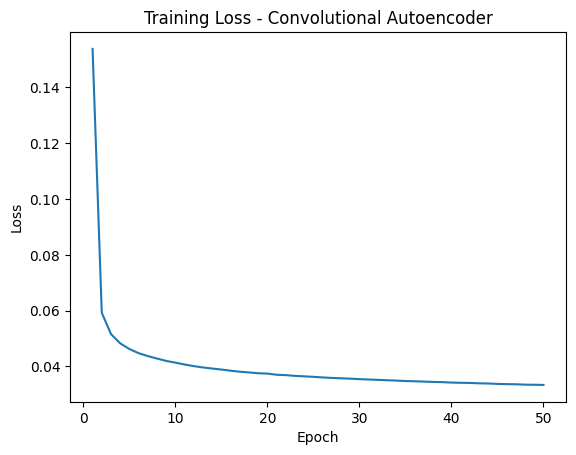

Mean MSE on test dataset - Convolutional Autoencoder: 0.03677


In [29]:
seed_everything(464)
model_conv = MnistAutoencoderConv() ## Uncomment when the model is implemented

# Set hyperparameters
learning_rate = 2e-4
num_epochs = 50

# Define the loss function
loss_func = nn.MSELoss()

# Create the optimizer
optimizer = optim.Adam(model_conv.parameters(), lr=learning_rate)

# Train the model
losses_conv = train_model(model_conv, train_dataloader, optimizer, loss_func, num_epochs)

# Visualize the losses
plt.plot(range(1, num_epochs + 1), losses_conv)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss - Convolutional Autoencoder')
plt.show()

# Evaluate the model
mean_mse_conv = evaluate_model(model_conv, test_dataloader)
print(f"Mean MSE on test dataset - Convolutional Autoencoder: {mean_mse_conv:.5f}")

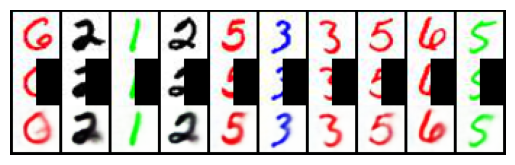

In [30]:
visualize_inpainting(model_conv, test_dataset) ## Uncomment when the model is trained

### **Discussion [10 Points]**

Discuss the results that you obtained after training the models. Compare the inpainting performances by the visualizations and the accuracy metrics. You can write your answer in the below cell.

---
The mean MSE for Fully Connected Autoencoder is 0.04774 and ultimately it achieved 0.047 loss. On the other hand, for the Convolutional Autoencoder, the mean MSE is 0.03677 and it ultimately achieved 0.033 loss. 

According to these data, the convolutional autoencoder outperforms the fully connected autoencoder in terms of mean squared error (MSE) on the test dataset. The convolutional architecture is better suited for image processing tasks as it can capture spatial relationships and hierarchical features, while the fully connected architecture lacks the ability to preserve spatial structure.  Therefore, the convolutional autoencoder achieves more accurate reconstructions and lower MSE values compared to the fully connected autoencoder. Also, in the inpaintings, it can be seen that Convolutional Autoencoder reproduced much more crisp and detailed images when compared to Fully Connected Autoencoder.

---